# V1 Network Architecture Visualization

This notebook visualizes the neural network architectures used for track extrapolation:

1. **MLP (Multi-Layer Perceptron)** - Standard feedforward network
2. **PINN (Physics-Informed Neural Network)** - Network with physics loss
3. **RK_PINN (Runge-Kutta PINN)** - Multi-stage architecture inspired by RK4

For each architecture, we'll show:
- Network structure diagram
- Layer sizes and parameter counts
- Training flow (especially for PINNs)

In [13]:
import sys
import os
sys.path.insert(0, os.path.abspath('../models'))
sys.path.insert(0, os.path.abspath('../utils'))

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Rectangle, Circle
from matplotlib.collections import PatchCollection
import json
from pathlib import Path

# Import our architectures
from architectures import MLP, PINN, RK_PINN, create_model, ARCHITECTURE_PRESETS

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10

print("Imports successful!")

Imports successful!


## 1. MLP Architecture Visualization

The MLP is a simple feedforward network:
```
Input [6] → Normalize → [Linear→SiLU]×N → Linear → Denormalize → Output [4]
```

/tmp/ipykernel_892436/1051591005.py:124: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


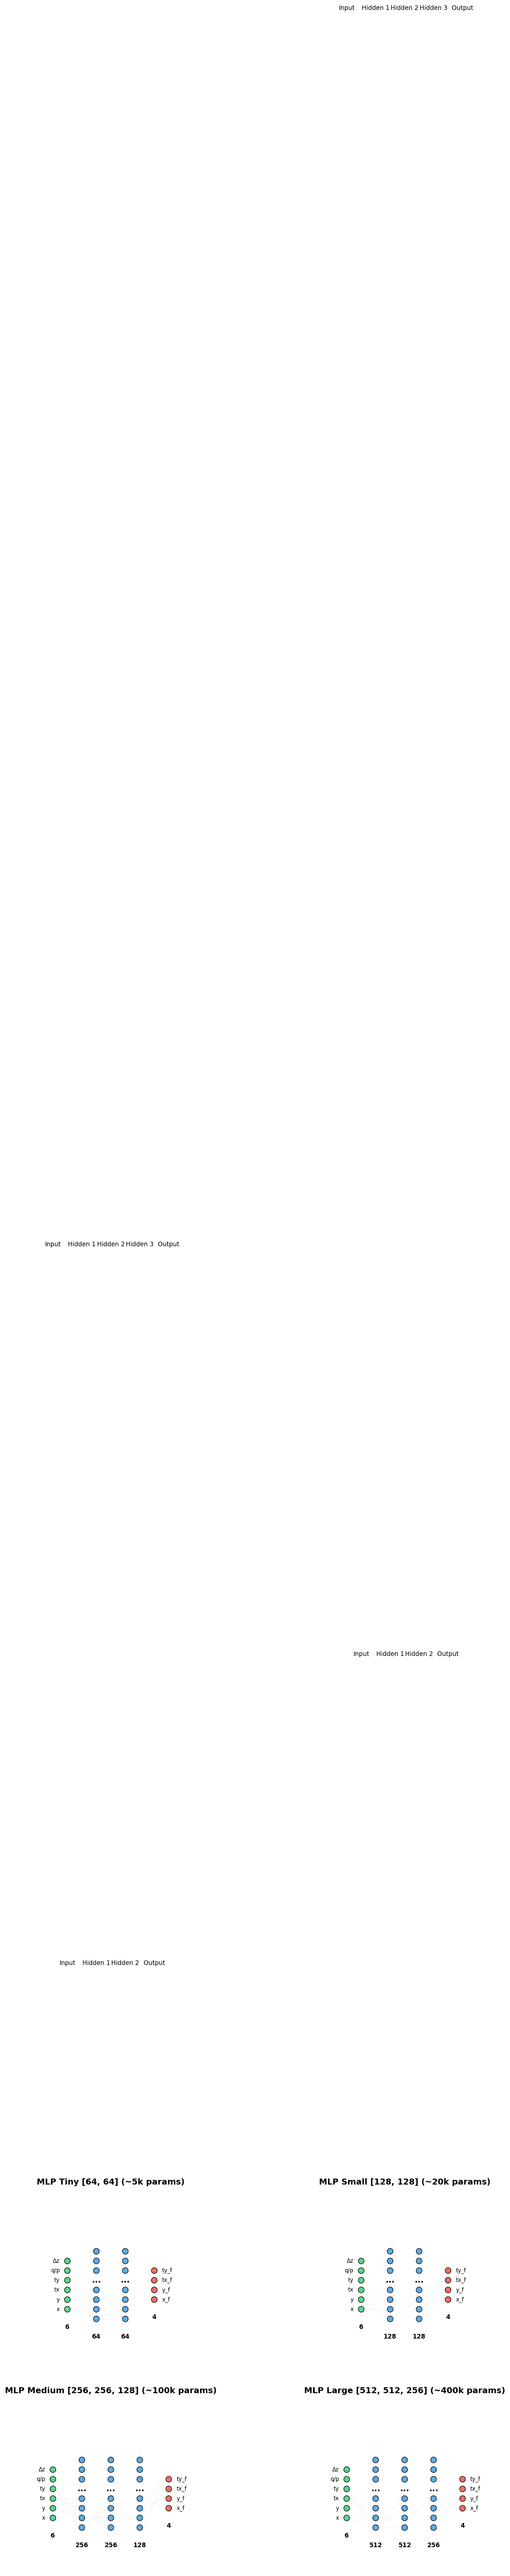

MLP architectures saved to plots/mlp_architectures.png


In [2]:
def draw_network_architecture(ax, layer_sizes, title, input_labels=None, output_labels=None, colors=None):
    """
    Draw a neural network architecture diagram.
    
    Args:
        ax: matplotlib axis
        layer_sizes: list of layer sizes [input, hidden1, hidden2, ..., output]
        title: plot title
        input_labels: labels for input neurons
        output_labels: labels for output neurons
        colors: dict of colors for different layer types
    """
    if colors is None:
        colors = {
            'input': '#2ecc71',      # Green
            'hidden': '#3498db',     # Blue
            'output': '#e74c3c',     # Red
            'connection': '#bdc3c7', # Gray
        }
    
    n_layers = len(layer_sizes)
    max_neurons = max(layer_sizes)
    
    # Spacing
    layer_spacing = 1.5
    neuron_spacing = 0.5
    neuron_radius = 0.15
    max_display = 8  # Max neurons to display per layer
    
    # Store neuron positions
    positions = []
    
    for layer_idx, n_neurons in enumerate(layer_sizes):
        x = layer_idx * layer_spacing
        
        # Limit display neurons
        display_neurons = min(n_neurons, max_display)
        show_ellipsis = n_neurons > max_display
        
        # Center vertically
        start_y = -(display_neurons - 1) * neuron_spacing / 2
        
        layer_positions = []
        for i in range(display_neurons):
            if show_ellipsis and i == max_display // 2:
                # Show ellipsis instead of middle neuron
                y = start_y + i * neuron_spacing
                ax.text(x, y, '...', ha='center', va='center', fontsize=12, fontweight='bold')
                layer_positions.append((x, y))
            else:
                y = start_y + i * neuron_spacing
                
                # Color based on layer type
                if layer_idx == 0:
                    color = colors['input']
                elif layer_idx == n_layers - 1:
                    color = colors['output']
                else:
                    color = colors['hidden']
                
                circle = Circle((x, y), neuron_radius, fc=color, ec='black', lw=1, alpha=0.8)
                ax.add_patch(circle)
                layer_positions.append((x, y))
        
        positions.append(layer_positions)
        
        # Layer label
        ax.text(x, start_y - neuron_spacing * 1.5, f'{n_neurons}', 
                ha='center', va='top', fontsize=9, fontweight='bold')
    
    # Draw connections (sample of connections to avoid clutter)
    for layer_idx in range(n_layers - 1):
        layer1 = positions[layer_idx]
        layer2 = positions[layer_idx + 1]
        
        # Sample connections
        for i, (x1, y1) in enumerate(layer1[:min(4, len(layer1))]):
            for j, (x2, y2) in enumerate(layer2[:min(4, len(layer2))]):
                if np.random.random() < 0.3:  # Random sampling
                    ax.plot([x1 + neuron_radius, x2 - neuron_radius], [y1, y2],
                           color=colors['connection'], alpha=0.3, lw=0.5)
    
    # Input/output labels
    if input_labels:
        for i, label in enumerate(input_labels[:min(len(input_labels), len(positions[0]))]):
            x, y = positions[0][i]
            ax.text(x - 0.4, y, label, ha='right', va='center', fontsize=8)
    
    if output_labels:
        for i, label in enumerate(output_labels[:min(len(output_labels), len(positions[-1]))]):
            x, y = positions[-1][i]
            ax.text(x + 0.4, y, label, ha='left', va='center', fontsize=8)
    
    # Layer type labels
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(n_layers - 2)] + ['Output']
    for i, label in enumerate(layer_labels):
        x = i * layer_spacing
        ax.text(x, max(max_display, max_neurons) * neuron_spacing / 2 + 0.5, label,
               ha='center', va='bottom', fontsize=9)
    
    ax.set_xlim(-1, (n_layers - 1) * layer_spacing + 1)
    ax.set_ylim(-max_display * neuron_spacing, max_display * neuron_spacing + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')

# Create figure for MLP architectures
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

input_labels = ['x', 'y', 'tx', 'ty', 'q/p', 'Δz']
output_labels = ['x_f', 'y_f', 'tx_f', 'ty_f']

# V1 MLP architectures from trained models
mlp_configs = [
    ([6, 64, 64, 4], 'MLP Tiny [64, 64] (~5k params)'),
    ([6, 128, 128, 4], 'MLP Small [128, 128] (~20k params)'),
    ([6, 256, 256, 128, 4], 'MLP Medium [256, 256, 128] (~100k params)'),
    ([6, 512, 512, 256, 4], 'MLP Large [512, 512, 256] (~400k params)'),
]

for ax, (layers, title) in zip(axes.flat, mlp_configs):
    draw_network_architecture(ax, layers, title, input_labels, output_labels)

plt.tight_layout()
plt.savefig('plots/mlp_architectures.png', dpi=150, bbox_inches='tight')
plt.show()
print("MLP architectures saved to plots/mlp_architectures.png")

## 2. PINN Architecture & Training Flow

The PINN uses the same network structure as MLP, but with additional physics-based loss terms:

```
Training Loss = L_data + λ_ic × L_ic + λ_pde × L_pde

Where:
- L_data: MSE at endpoint vs ground truth
- L_ic:   MSE at z=0 vs initial condition
- L_pde:  Σ ||∂y/∂z - F(y, B)||² at collocation points (Lorentz force residual)
```

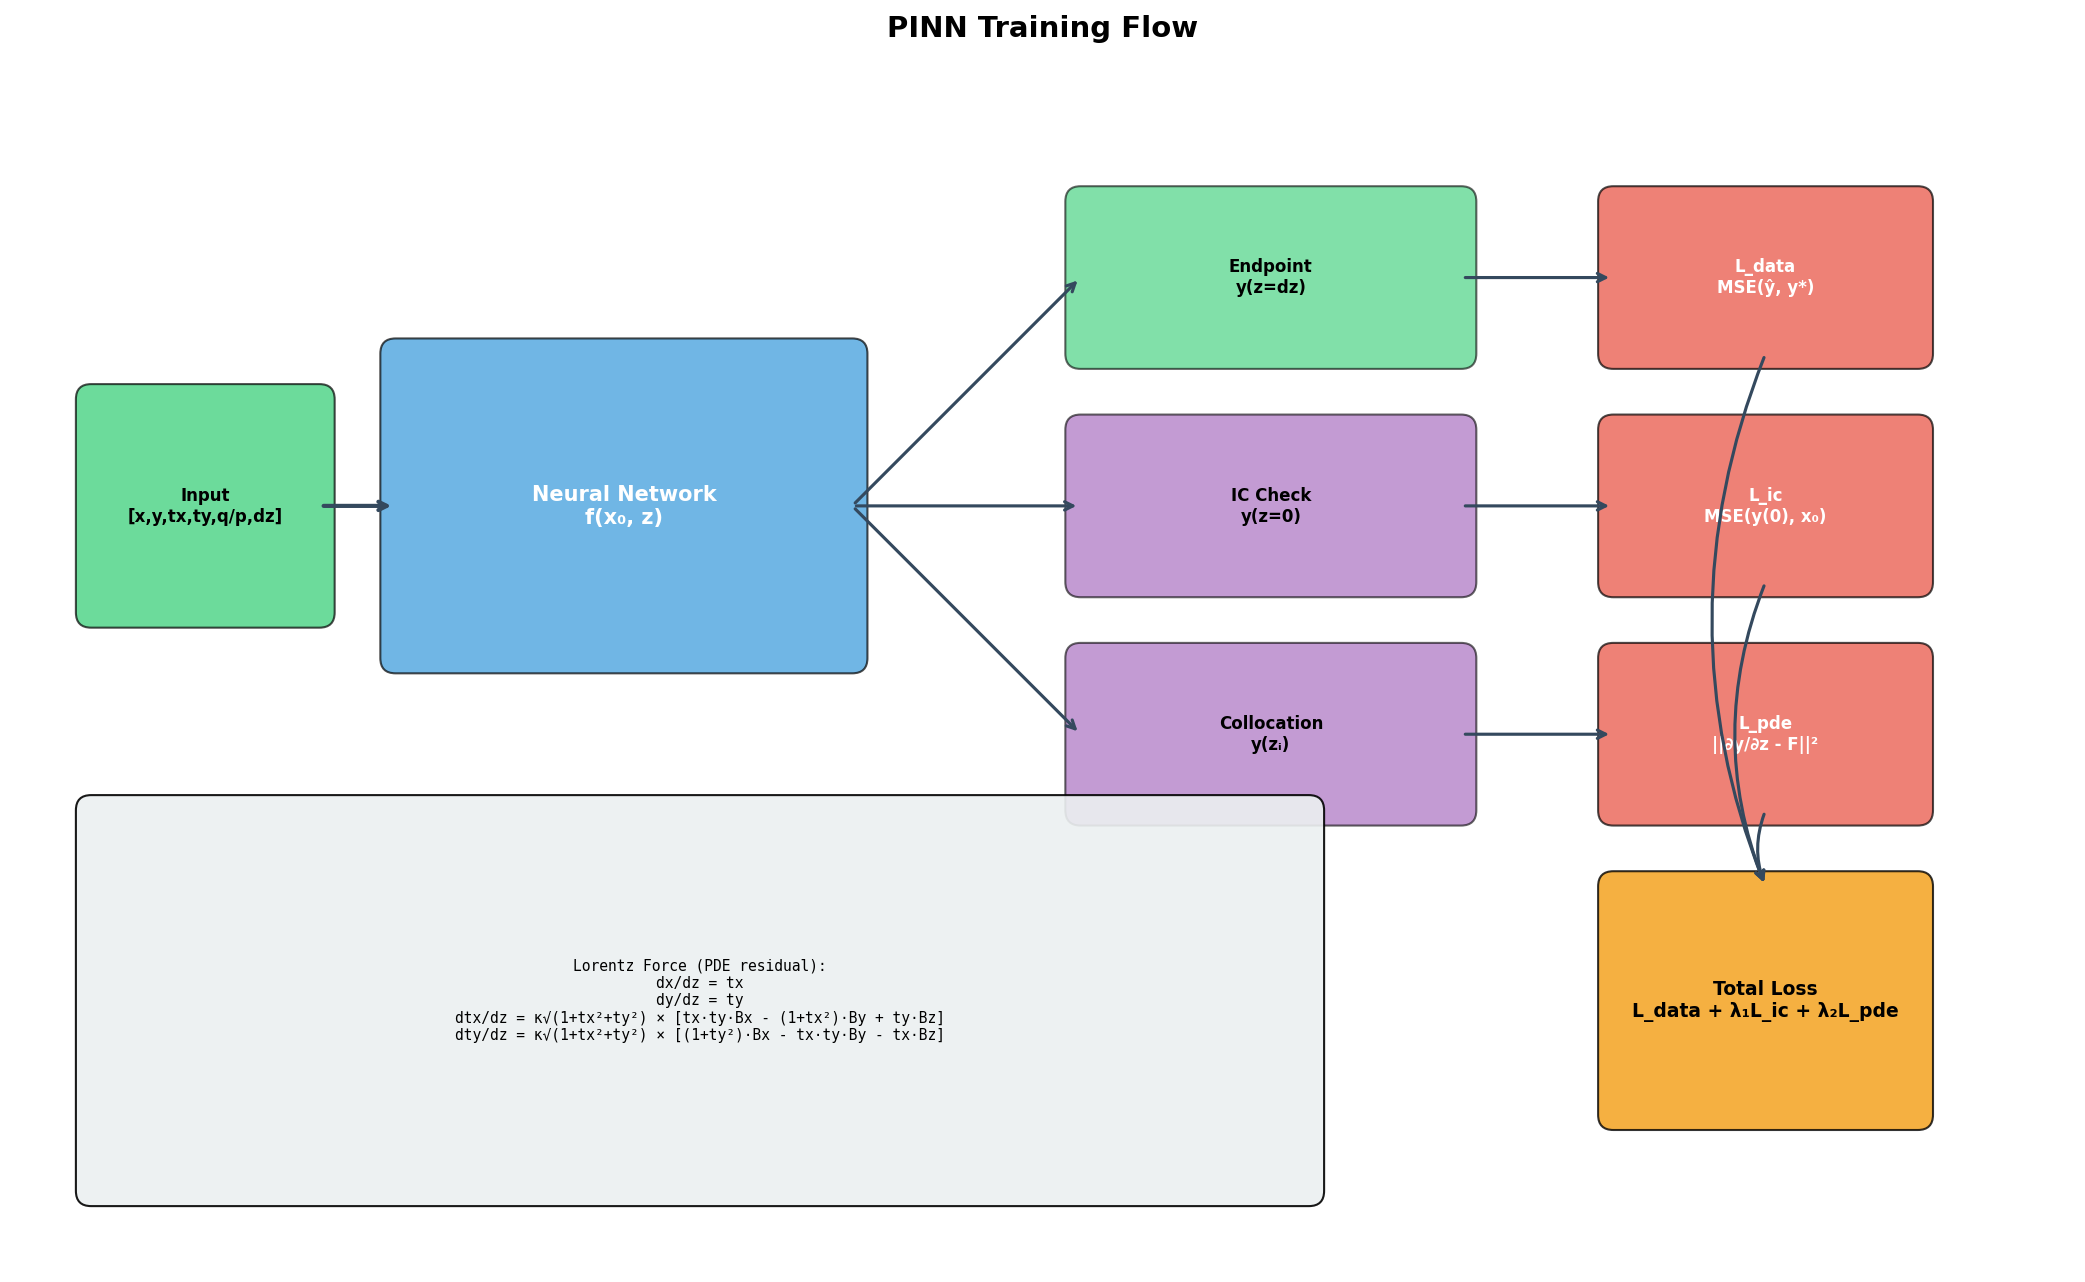

PINN training flow saved to plots/pinn_training_flow.png


In [3]:
def draw_pinn_training_flow(ax):
    """
    Draw PINN training flow diagram showing how physics loss is computed.
    """
    colors = {
        'network': '#3498db',
        'loss': '#e74c3c',
        'physics': '#9b59b6',
        'data': '#2ecc71',
        'arrow': '#34495e'
    }
    
    # Network box
    network_box = FancyBboxPatch((2, 4), 3, 2, boxstyle="round,pad=0.1",
                                  fc=colors['network'], ec='black', alpha=0.7)
    ax.add_patch(network_box)
    ax.text(3.5, 5, 'Neural Network\nf(x₀, z)', ha='center', va='center', 
            fontsize=10, fontweight='bold', color='white')
    
    # Input box
    input_box = FancyBboxPatch((0, 4.3), 1.5, 1.4, boxstyle="round,pad=0.1",
                                fc=colors['data'], ec='black', alpha=0.7)
    ax.add_patch(input_box)
    ax.text(0.75, 5, 'Input\n[x,y,tx,ty,q/p,dz]', ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Arrow from input to network
    ax.annotate('', xy=(2, 5), xytext=(1.5, 5),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=2))
    
    # Three output branches
    branches = [
        (6.5, 6.5, 'Endpoint\ny(z=dz)', colors['data']),
        (6.5, 5, 'IC Check\ny(z=0)', colors['physics']),
        (6.5, 3.5, 'Collocation\ny(zᵢ)', colors['physics']),
    ]
    
    for x, y, text, color in branches:
        box = FancyBboxPatch((x, y-0.5), 2.5, 1, boxstyle="round,pad=0.1",
                             fc=color, ec='black', alpha=0.6)
        ax.add_patch(box)
        ax.text(x + 1.25, y, text, ha='center', va='center', fontsize=8, fontweight='bold')
        ax.annotate('', xy=(x, y), xytext=(5, 5),
                   arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5))
    
    # Loss computation boxes
    losses = [
        (10, 6.5, 'L_data\nMSE(ŷ, y*)', colors['loss']),
        (10, 5, 'L_ic\nMSE(y(0), x₀)', colors['loss']),
        (10, 3.5, 'L_pde\n||∂y/∂z - F||²', colors['loss']),
    ]
    
    for x, y, text, color in losses:
        box = FancyBboxPatch((x, y-0.5), 2, 1, boxstyle="round,pad=0.1",
                             fc=color, ec='black', alpha=0.7)
        ax.add_patch(box)
        ax.text(x + 1, y, text, ha='center', va='center', fontsize=8, fontweight='bold', color='white')
        ax.annotate('', xy=(x, y), xytext=(9, y),
                   arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5))
    
    # Total loss box
    total_box = FancyBboxPatch((10, 1), 2, 1.5, boxstyle="round,pad=0.1",
                                fc='#f39c12', ec='black', alpha=0.8)
    ax.add_patch(total_box)
    ax.text(11, 1.75, 'Total Loss\nL_data + λ₁L_ic + λ₂L_pde', ha='center', va='center', 
            fontsize=9, fontweight='bold')
    
    # Arrows to total
    for y in [6.5, 5, 3.5]:
        ax.annotate('', xy=(11, 2.5), xytext=(11, y-0.5),
                   arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5,
                                  connectionstyle='arc3,rad=0.2'))
    
    # Physics equations box
    physics_box = FancyBboxPatch((0, 0.5), 8, 2.5, boxstyle="round,pad=0.1",
                                  fc='#ecf0f1', ec='black', alpha=0.9)
    ax.add_patch(physics_box)
    physics_text = "Lorentz Force (PDE residual):\n"
    physics_text += "dx/dz = tx\n"
    physics_text += "dy/dz = ty\n"
    physics_text += "dtx/dz = κ√(1+tx²+ty²) × [tx·ty·Bx - (1+tx²)·By + ty·Bz]\n"
    physics_text += "dty/dz = κ√(1+tx²+ty²) × [(1+ty²)·Bx - tx·ty·By - tx·Bz]"
    ax.text(4, 1.75, physics_text, ha='center', va='center', fontsize=7, family='monospace')
    
    ax.set_xlim(-0.5, 13)
    ax.set_ylim(0, 8)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('PINN Training Flow', fontsize=14, fontweight='bold')

# Create PINN visualization
fig, ax = plt.subplots(figsize=(14, 9))
draw_pinn_training_flow(ax)
plt.tight_layout()
plt.savefig('plots/pinn_training_flow.png', dpi=150, bbox_inches='tight')
plt.show()
print("PINN training flow saved to plots/pinn_training_flow.png")

## 3. RK_PINN Multi-Stage Architecture

The RK_PINN uses a multi-stage architecture inspired by RK4 integration:

```
Input → Shared Backbone → [Head₁(z=0.25), Head₂(z=0.5), Head₃(z=0.75), Head₄(z=1.0)]
                                              ↓
                            Weighted combination: w₁k₁ + w₂k₂ + w₃k₃ + w₄k₄
                            (weights initialized to RK4: [1, 2, 2, 1]/6)
```

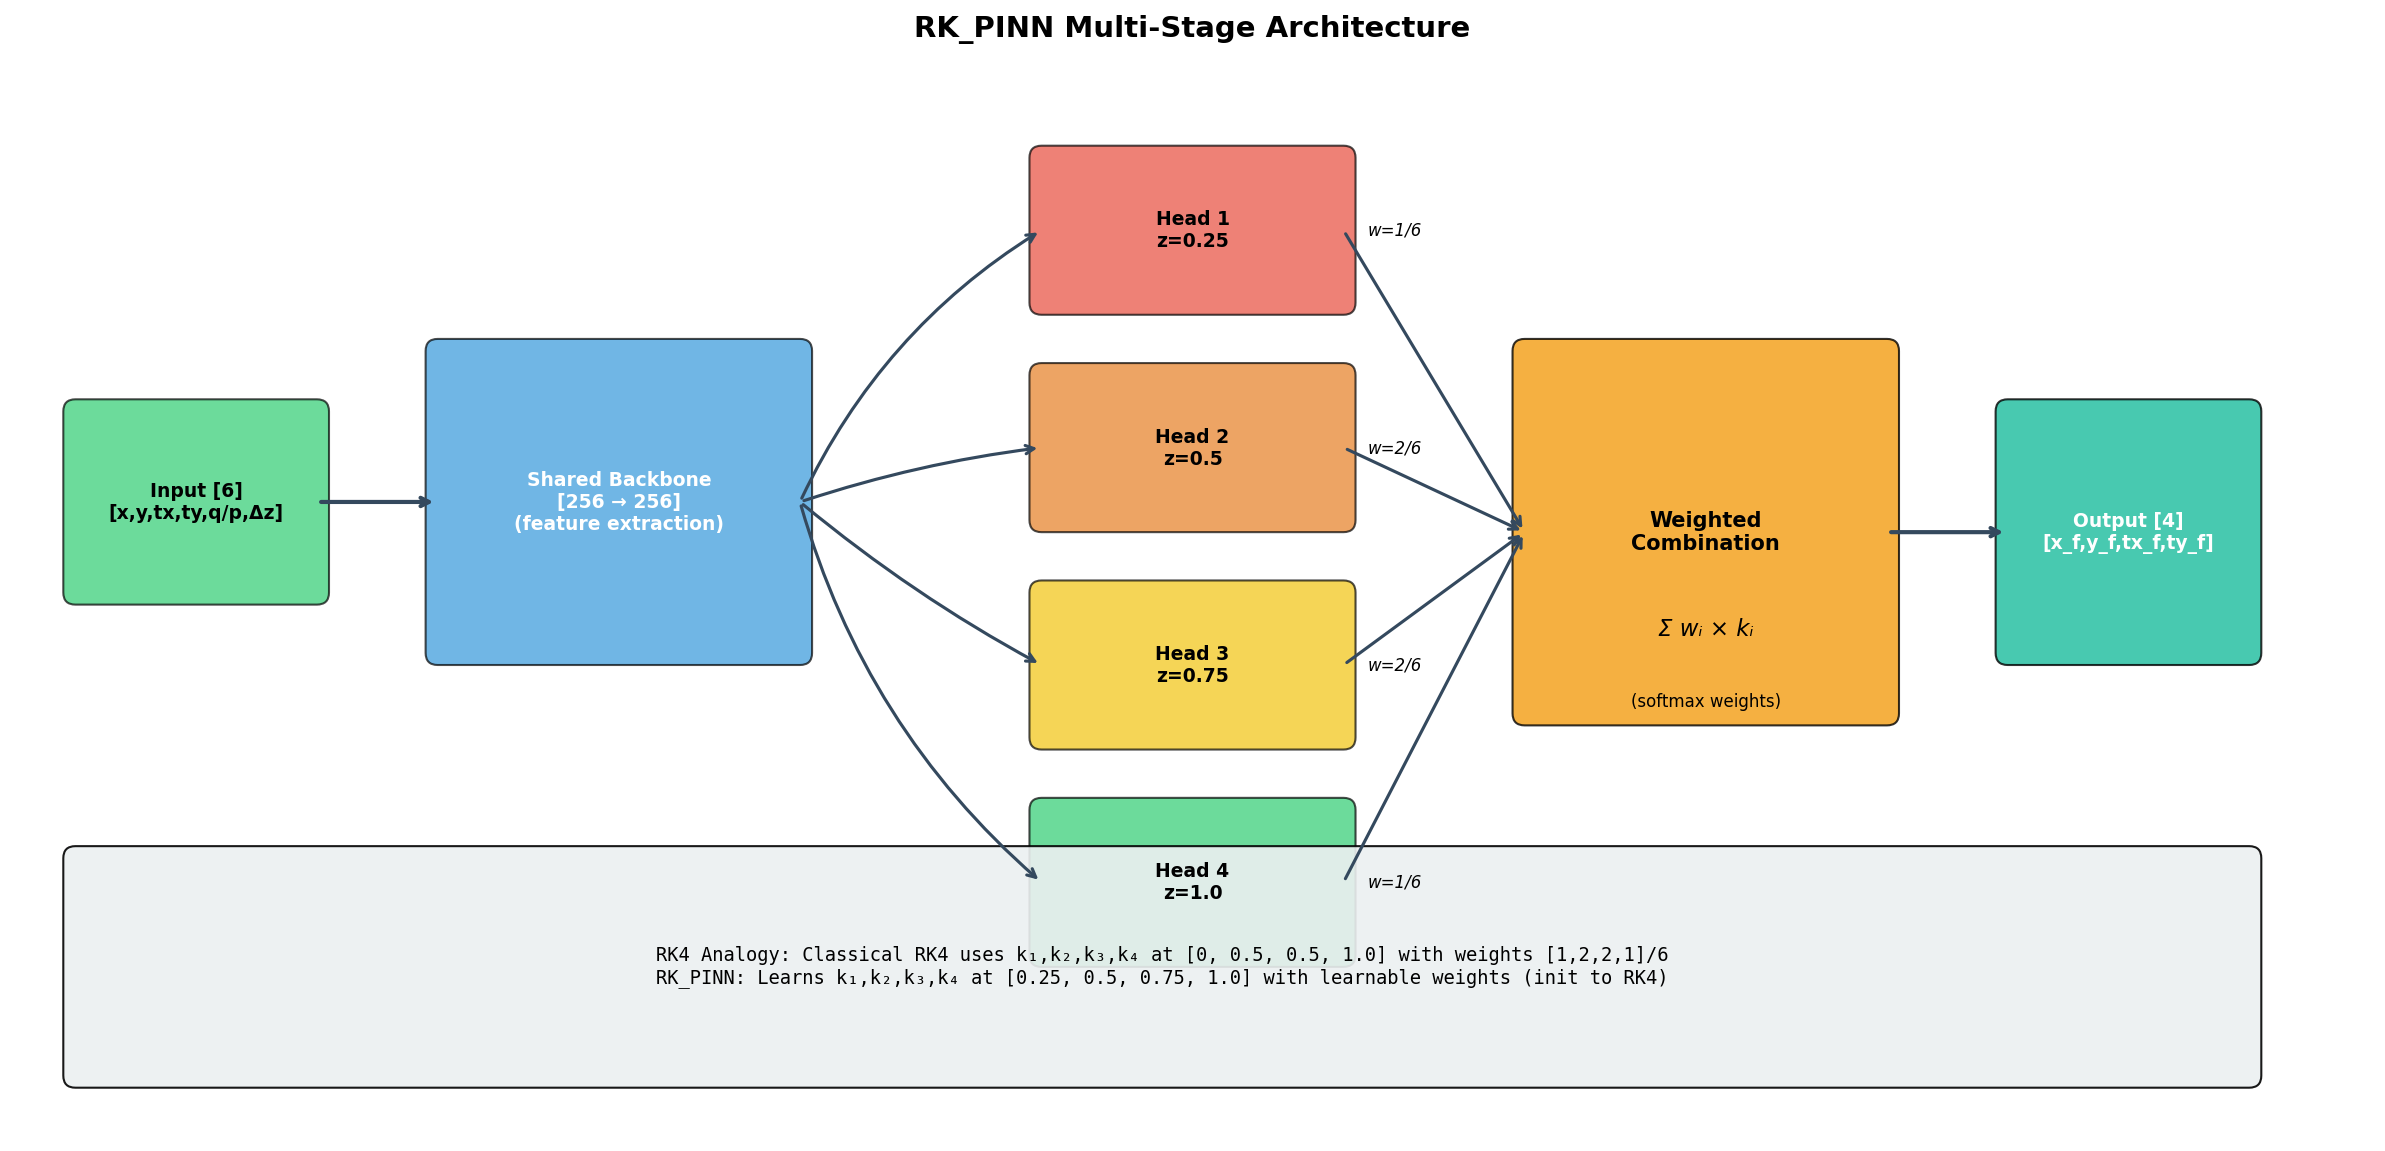

RK_PINN architecture saved to plots/rk_pinn_architecture.png


In [4]:
def draw_rk_pinn_architecture(ax):
    """
    Draw RK_PINN multi-stage architecture diagram.
    """
    colors = {
        'backbone': '#3498db',
        'head': '#9b59b6',
        'stage': ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71'],
        'output': '#1abc9c',
        'arrow': '#34495e'
    }
    
    # Input
    input_box = FancyBboxPatch((0, 3.5), 2, 1.5, boxstyle="round,pad=0.1",
                                fc='#2ecc71', ec='black', alpha=0.7)
    ax.add_patch(input_box)
    ax.text(1, 4.25, 'Input [6]\n[x,y,tx,ty,q/p,Δz]', ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Shared Backbone
    backbone_box = FancyBboxPatch((3, 3), 3, 2.5, boxstyle="round,pad=0.1",
                                   fc=colors['backbone'], ec='black', alpha=0.7)
    ax.add_patch(backbone_box)
    ax.text(4.5, 4.25, 'Shared Backbone\n[256 → 256]\n(feature extraction)', 
            ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax.annotate('', xy=(3, 4.25), xytext=(2, 4.25),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=2))
    
    # Stage heads
    stage_labels = ['z=0.25', 'z=0.5', 'z=0.75', 'z=1.0']
    rk_weights = [1, 2, 2, 1]
    
    for i, (label, weight, color) in enumerate(zip(stage_labels, rk_weights, colors['stage'])):
        x = 8
        y = 6.5 - i * 1.8
        
        # Head box
        head_box = FancyBboxPatch((x, y-0.6), 2.5, 1.2, boxstyle="round,pad=0.1",
                                   fc=color, ec='black', alpha=0.7)
        ax.add_patch(head_box)
        ax.text(x + 1.25, y, f'Head {i+1}\n{label}', ha='center', va='center', 
                fontsize=9, fontweight='bold')
        
        # Arrow from backbone
        ax.annotate('', xy=(8, y), xytext=(6, 4.25),
                   arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5,
                                  connectionstyle=f'arc3,rad={0.1*(i-1.5)}'))
        
        # Weight annotation
        ax.text(x + 2.7, y, f'w={weight}/6', fontsize=8, va='center', style='italic')
    
    # Combination box
    combine_box = FancyBboxPatch((12, 2.5), 3, 3, boxstyle="round,pad=0.1",
                                  fc='#f39c12', ec='black', alpha=0.8)
    ax.add_patch(combine_box)
    ax.text(13.5, 4, 'Weighted\nCombination', ha='center', va='center', 
            fontsize=10, fontweight='bold')
    ax.text(13.5, 3.2, 'Σ wᵢ × kᵢ', ha='center', va='center', fontsize=11, style='italic')
    ax.text(13.5, 2.6, '(softmax weights)', ha='center', va='center', fontsize=8)
    
    # Arrows to combination
    for i in range(4):
        y = 6.5 - i * 1.8
        ax.annotate('', xy=(12, 4), xytext=(10.5, y),
                   arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5))
    
    # Output
    output_box = FancyBboxPatch((16, 3), 2, 2, boxstyle="round,pad=0.1",
                                 fc=colors['output'], ec='black', alpha=0.8)
    ax.add_patch(output_box)
    ax.text(17, 4, 'Output [4]\n[x_f,y_f,tx_f,ty_f]', ha='center', va='center', 
            fontsize=9, fontweight='bold', color='white')
    
    ax.annotate('', xy=(16, 4), xytext=(15, 4),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=2))
    
    # RK4 analogy note
    rk_note = FancyBboxPatch((0, -0.5), 18, 1.8, boxstyle="round,pad=0.1",
                              fc='#ecf0f1', ec='black', alpha=0.9)
    ax.add_patch(rk_note)
    note_text = "RK4 Analogy: Classical RK4 uses k₁,k₂,k₃,k₄ at [0, 0.5, 0.5, 1.0] with weights [1,2,2,1]/6\n"
    note_text += "RK_PINN: Learns k₁,k₂,k₃,k₄ at [0.25, 0.5, 0.75, 1.0] with learnable weights (init to RK4)"
    ax.text(9, 0.4, note_text, ha='center', va='center', fontsize=9, family='monospace')
    
    ax.set_xlim(-0.5, 19)
    ax.set_ylim(-1, 8)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('RK_PINN Multi-Stage Architecture', fontsize=14, fontweight='bold')

# Create RK_PINN visualization
fig, ax = plt.subplots(figsize=(16, 8))
draw_rk_pinn_architecture(ax)
plt.tight_layout()
plt.savefig('plots/rk_pinn_architecture.png', dpi=150, bbox_inches='tight')
plt.show()
print("RK_PINN architecture saved to plots/rk_pinn_architecture.png")

## 3.5 PINN Loss Visualization with Trajectory

This visualization shows how the PINN loss function works:
- **Trajectory**: The network predicts state y(z) along the full path
- **Initial Condition (IC)**: At z=0, prediction must match input state
- **Collocation Points**: PDE residual computed at multiple z positions
- **Endpoint**: Data loss computed against ground truth

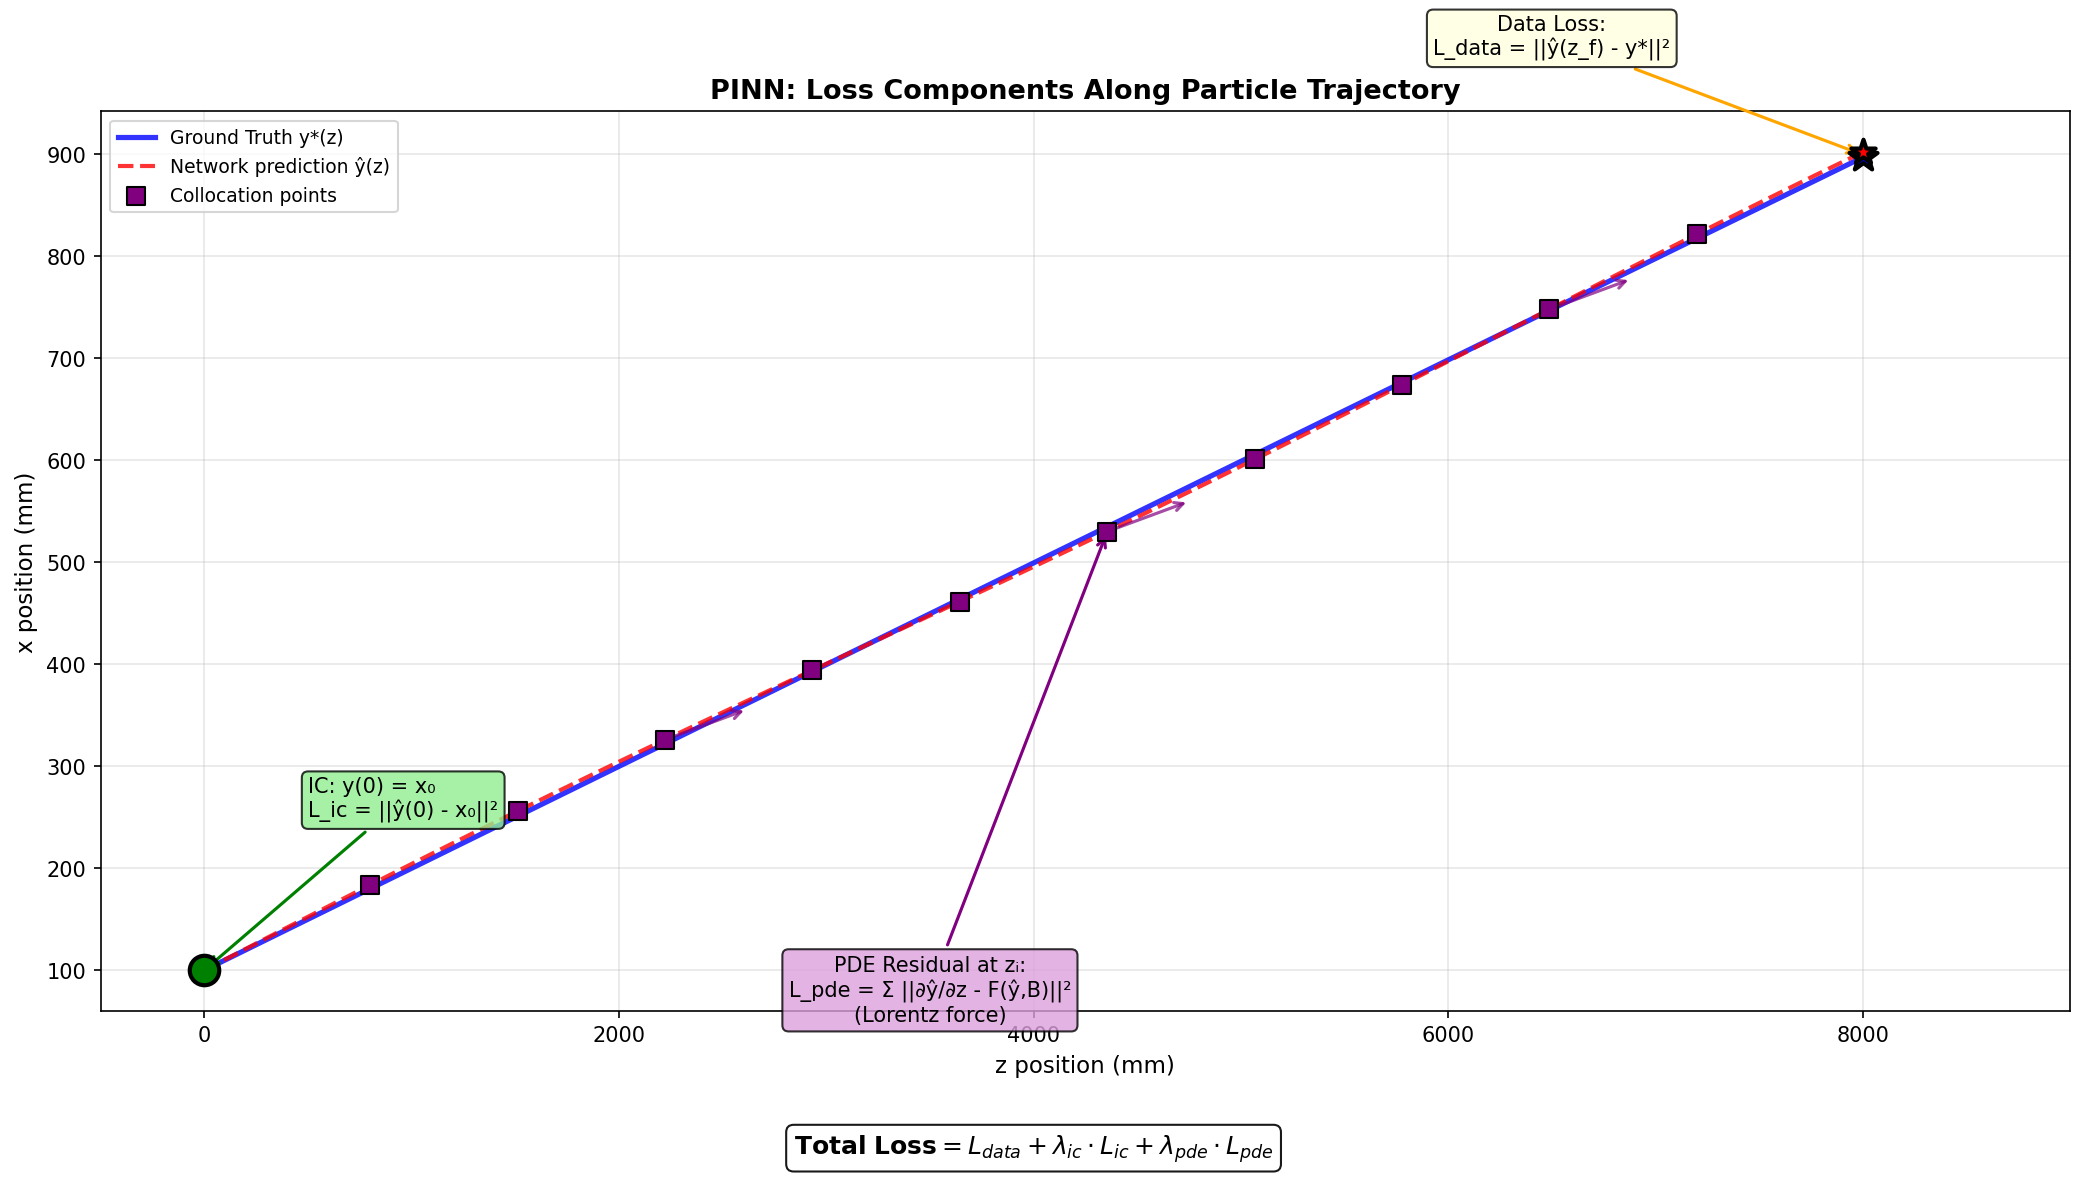

PINN trajectory loss visualization saved to plots/pinn_trajectory_loss.png


In [9]:
def visualize_pinn_trajectory_loss(ax):
    """
    Visualize PINN loss computation along a particle trajectory.
    Shows how IC loss, PDE residual at collocation points, and data loss work.
    """
    # Simulate a curved trajectory (x vs z) for a charged particle
    z = np.linspace(0, 8000, 100)  # mm
    
    # Approximate trajectory shape (particle bending in magnetic field)
    # x(z) = x0 + tx0*z + 0.5*curvature*z^2
    x0, tx0 = 100, 0.1  # initial position and slope
    curvature = -1e-7   # bending due to magnetic field
    x_true = x0 + tx0 * z + 0.5 * curvature * z**2
    
    # "Network prediction" (slightly different from truth to show errors)
    x_pred = x0 + tx0 * z + 0.5 * (curvature * 0.95) * z**2 + 5 * np.sin(z/1000)
    
    # Plot trajectories
    ax.plot(z, x_true, 'b-', lw=2.5, label='Ground Truth y*(z)', alpha=0.8)
    ax.plot(z, x_pred, 'r--', lw=2, label='Network prediction ŷ(z)', alpha=0.8)
    
    # Mark initial condition (z=0)
    ax.scatter([0], [x0], s=200, c='green', marker='o', zorder=5, edgecolors='black', lw=2)
    ax.annotate('IC: y(0) = x₀\nL_ic = ||ŷ(0) - x₀||²', 
                xy=(0, x0), xytext=(500, x0 + 150),
                fontsize=10, ha='left',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5))
    
    # Collocation points for PDE residual
    n_collocation = 10
    z_coll = np.linspace(800, 7200, n_collocation)
    x_coll_pred = x0 + tx0 * z_coll + 0.5 * (curvature * 0.95) * z_coll**2 + 5 * np.sin(z_coll/1000)
    
    ax.scatter(z_coll, x_coll_pred, s=80, c='purple', marker='s', zorder=5, 
               edgecolors='black', lw=1, label='Collocation points')
    
    # Show PDE residual arrows at a few points
    for i in [2, 5, 8]:
        z_i = z_coll[i]
        x_i = x_coll_pred[i]
        # Arrow showing "derivative should match physics"
        ax.annotate('', xy=(z_i + 400, x_i + 30), xytext=(z_i, x_i),
                   arrowprops=dict(arrowstyle='->', color='purple', lw=1.5, alpha=0.7))
    
    ax.annotate('PDE Residual at zᵢ:\nL_pde = Σ ||∂ŷ/∂z - F(ŷ,B)||²\n(Lorentz force)', 
                xy=(z_coll[5], x_coll_pred[5]), xytext=(3500, x_pred.min() - 50),
                fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='purple', lw=1.5))
    
    # Endpoint (data loss)
    z_end, x_end_true, x_end_pred = z[-1], x_true[-1], x_pred[-1]
    ax.scatter([z_end], [x_end_true], s=200, c='blue', marker='*', zorder=5, edgecolors='black', lw=2)
    ax.scatter([z_end], [x_end_pred], s=150, c='red', marker='*', zorder=5, edgecolors='black', lw=2)
    
    # Error bar between prediction and truth at endpoint
    ax.plot([z_end, z_end], [x_end_true, x_end_pred], 'k-', lw=2)
    ax.annotate('Data Loss:\nL_data = ||ŷ(z_f) - y*||²', 
                xy=(z_end, (x_end_true + x_end_pred)/2), xytext=(z_end - 1500, x_end_true + 100),
                fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='orange', lw=1.5))
    
    # Total loss formula at bottom
    ax.text(4000, x_pred.min() - 180, 
            r'$\mathbf{Total\ Loss} = L_{data} + \lambda_{ic} \cdot L_{ic} + \lambda_{pde} \cdot L_{pde}$',
            fontsize=12, ha='center', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.9))
    
    ax.set_xlabel('z position (mm)', fontsize=11)
    ax.set_ylabel('x position (mm)', fontsize=11)
    ax.set_title('PINN: Loss Components Along Particle Trajectory', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-500, 9000)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))
visualize_pinn_trajectory_loss(ax)
plt.tight_layout()
plt.savefig('plots/pinn_trajectory_loss.png', dpi=150, bbox_inches='tight')
plt.show()
print("PINN trajectory loss visualization saved to plots/pinn_trajectory_loss.png")

## 3.6 RK_PINN Multi-Stage Loss Visualization

The RK_PINN predicts at 4 stage positions (z=0.25, 0.5, 0.75, 1.0 of total step).
Each stage contributes to the final prediction through learnable weights (initialized to RK4).

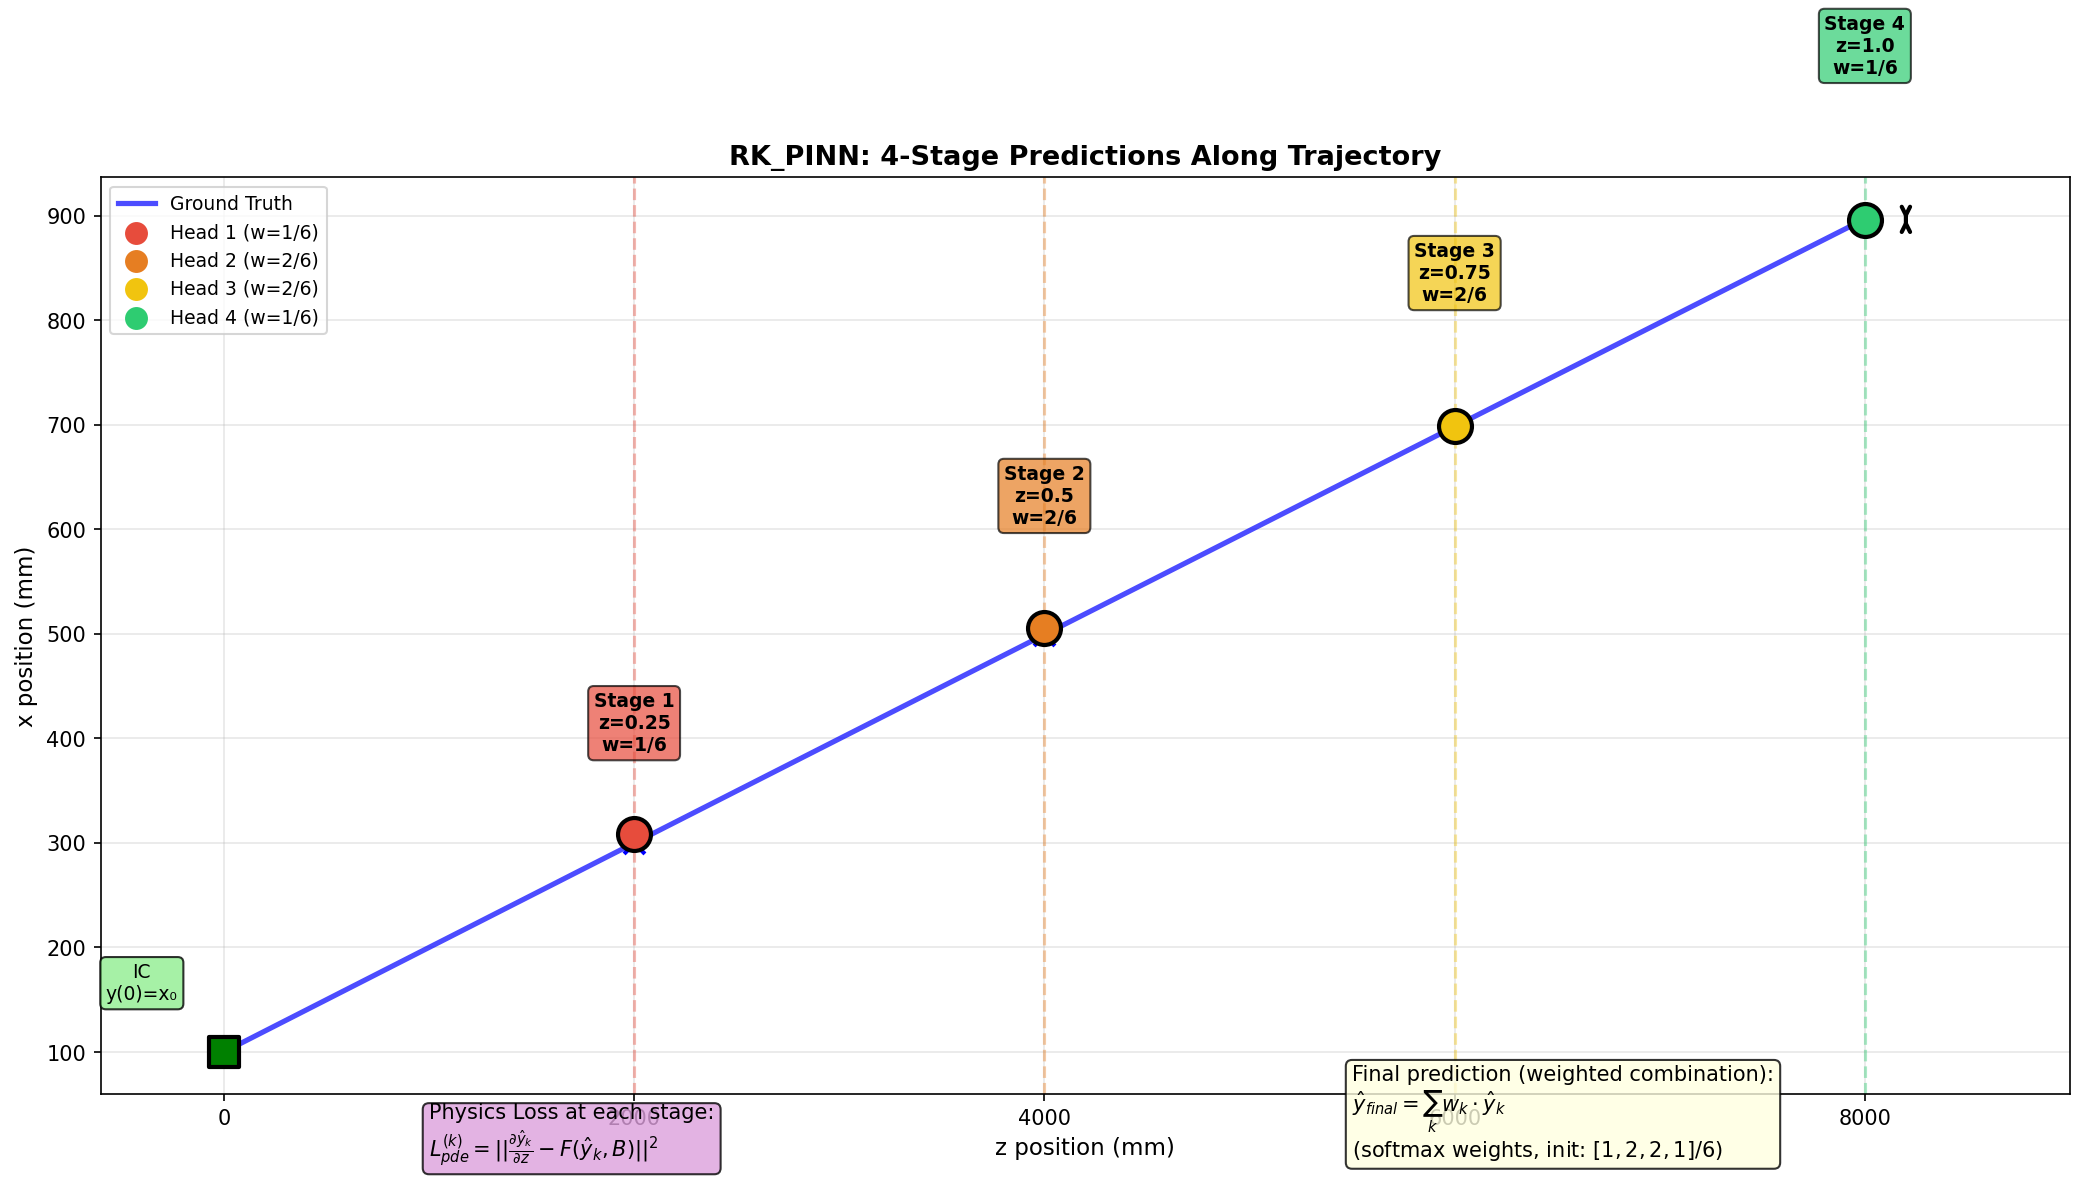

RK_PINN trajectory loss visualization saved to plots/rk_pinn_trajectory_loss.png


In [10]:
def visualize_rk_pinn_trajectory_loss(ax):
    """
    Visualize RK_PINN loss computation showing the 4 RK stages along trajectory.
    """
    # Simulate trajectory
    z = np.linspace(0, 8000, 100)
    z_max = 8000
    
    # True trajectory
    x0, tx0 = 100, 0.1
    curvature = -1e-7
    x_true = x0 + tx0 * z + 0.5 * curvature * z**2
    
    # Stage positions (RK_PINN uses [0.25, 0.5, 0.75, 1.0])
    stage_fracs = [0.25, 0.5, 0.75, 1.0]
    stage_z = [f * z_max for f in stage_fracs]
    rk4_weights = [1, 2, 2, 1]  # Standard RK4 weights (before /6)
    colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71']
    
    # Plot true trajectory
    ax.plot(z, x_true, 'b-', lw=2.5, label='Ground Truth', alpha=0.7)
    
    # Stage predictions (slightly different at each stage to show concept)
    stage_predictions = []
    for i, (z_s, w, c) in enumerate(zip(stage_z, rk4_weights, colors)):
        x_at_stage = x0 + tx0 * z_s + 0.5 * curvature * z_s**2
        # Add small stage-specific "error"
        x_pred_stage = x_at_stage + (10 - i*3) * np.sin(i + 1)
        stage_predictions.append(x_pred_stage)
        
        # Mark stage point
        ax.scatter([z_s], [x_pred_stage], s=250, c=c, marker='o', zorder=5, 
                   edgecolors='black', lw=2)
        ax.scatter([z_s], [x_at_stage], s=100, c='blue', marker='x', zorder=4, lw=2)
        
        # Vertical line to show stage position
        ax.axvline(z_s, color=c, linestyle='--', alpha=0.4, lw=1.5)
        
        # Label
        ax.annotate(f'Stage {i+1}\nz={stage_fracs[i]}\nw={w}/6',
                   xy=(z_s, x_pred_stage), xytext=(z_s, x_pred_stage + 80 + i*20),
                   fontsize=9, ha='center', fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor=c, alpha=0.7))
    
    # Show combination formula
    ax.annotate('', xy=(z_max + 200, stage_predictions[-1]), 
               xytext=(z_max + 200, x_true[-1]),
               arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    
    # Physics loss at each stage
    ax.text(1000, x_true.min() - 100,
            'Physics Loss at each stage:\n' + 
            r'$L_{pde}^{(k)} = ||\frac{\partial \hat{y}_k}{\partial z} - F(\hat{y}_k, B)||^2$',
            fontsize=10, ha='left',
            bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8))
    
    # Final combination
    ax.text(5500, x_true.min() - 100,
            'Final prediction (weighted combination):\n' + 
            r'$\hat{y}_{final} = \sum_k w_k \cdot \hat{y}_k$' + '\n' +
            r'(softmax weights, init: $[1,2,2,1]/6$)',
            fontsize=10, ha='left',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # Initial condition
    ax.scatter([0], [x0], s=200, c='green', marker='s', zorder=5, edgecolors='black', lw=2)
    ax.annotate('IC\ny(0)=x₀', xy=(0, x0), xytext=(-400, x0 + 50),
               fontsize=9, ha='center',
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Legend for stages
    for i, (c, w) in enumerate(zip(colors, rk4_weights)):
        ax.scatter([], [], s=100, c=c, marker='o', label=f'Head {i+1} (w={w}/6)')
    
    ax.set_xlabel('z position (mm)', fontsize=11)
    ax.set_ylabel('x position (mm)', fontsize=11)
    ax.set_title('RK_PINN: 4-Stage Predictions Along Trajectory', fontsize=13, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-600, 9000)

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))
visualize_rk_pinn_trajectory_loss(ax)
plt.tight_layout()
plt.savefig('plots/rk_pinn_trajectory_loss.png', dpi=150, bbox_inches='tight')
plt.show()
print("RK_PINN trajectory loss visualization saved to plots/rk_pinn_trajectory_loss.png")

## 4. Comparison of All V1 Architectures

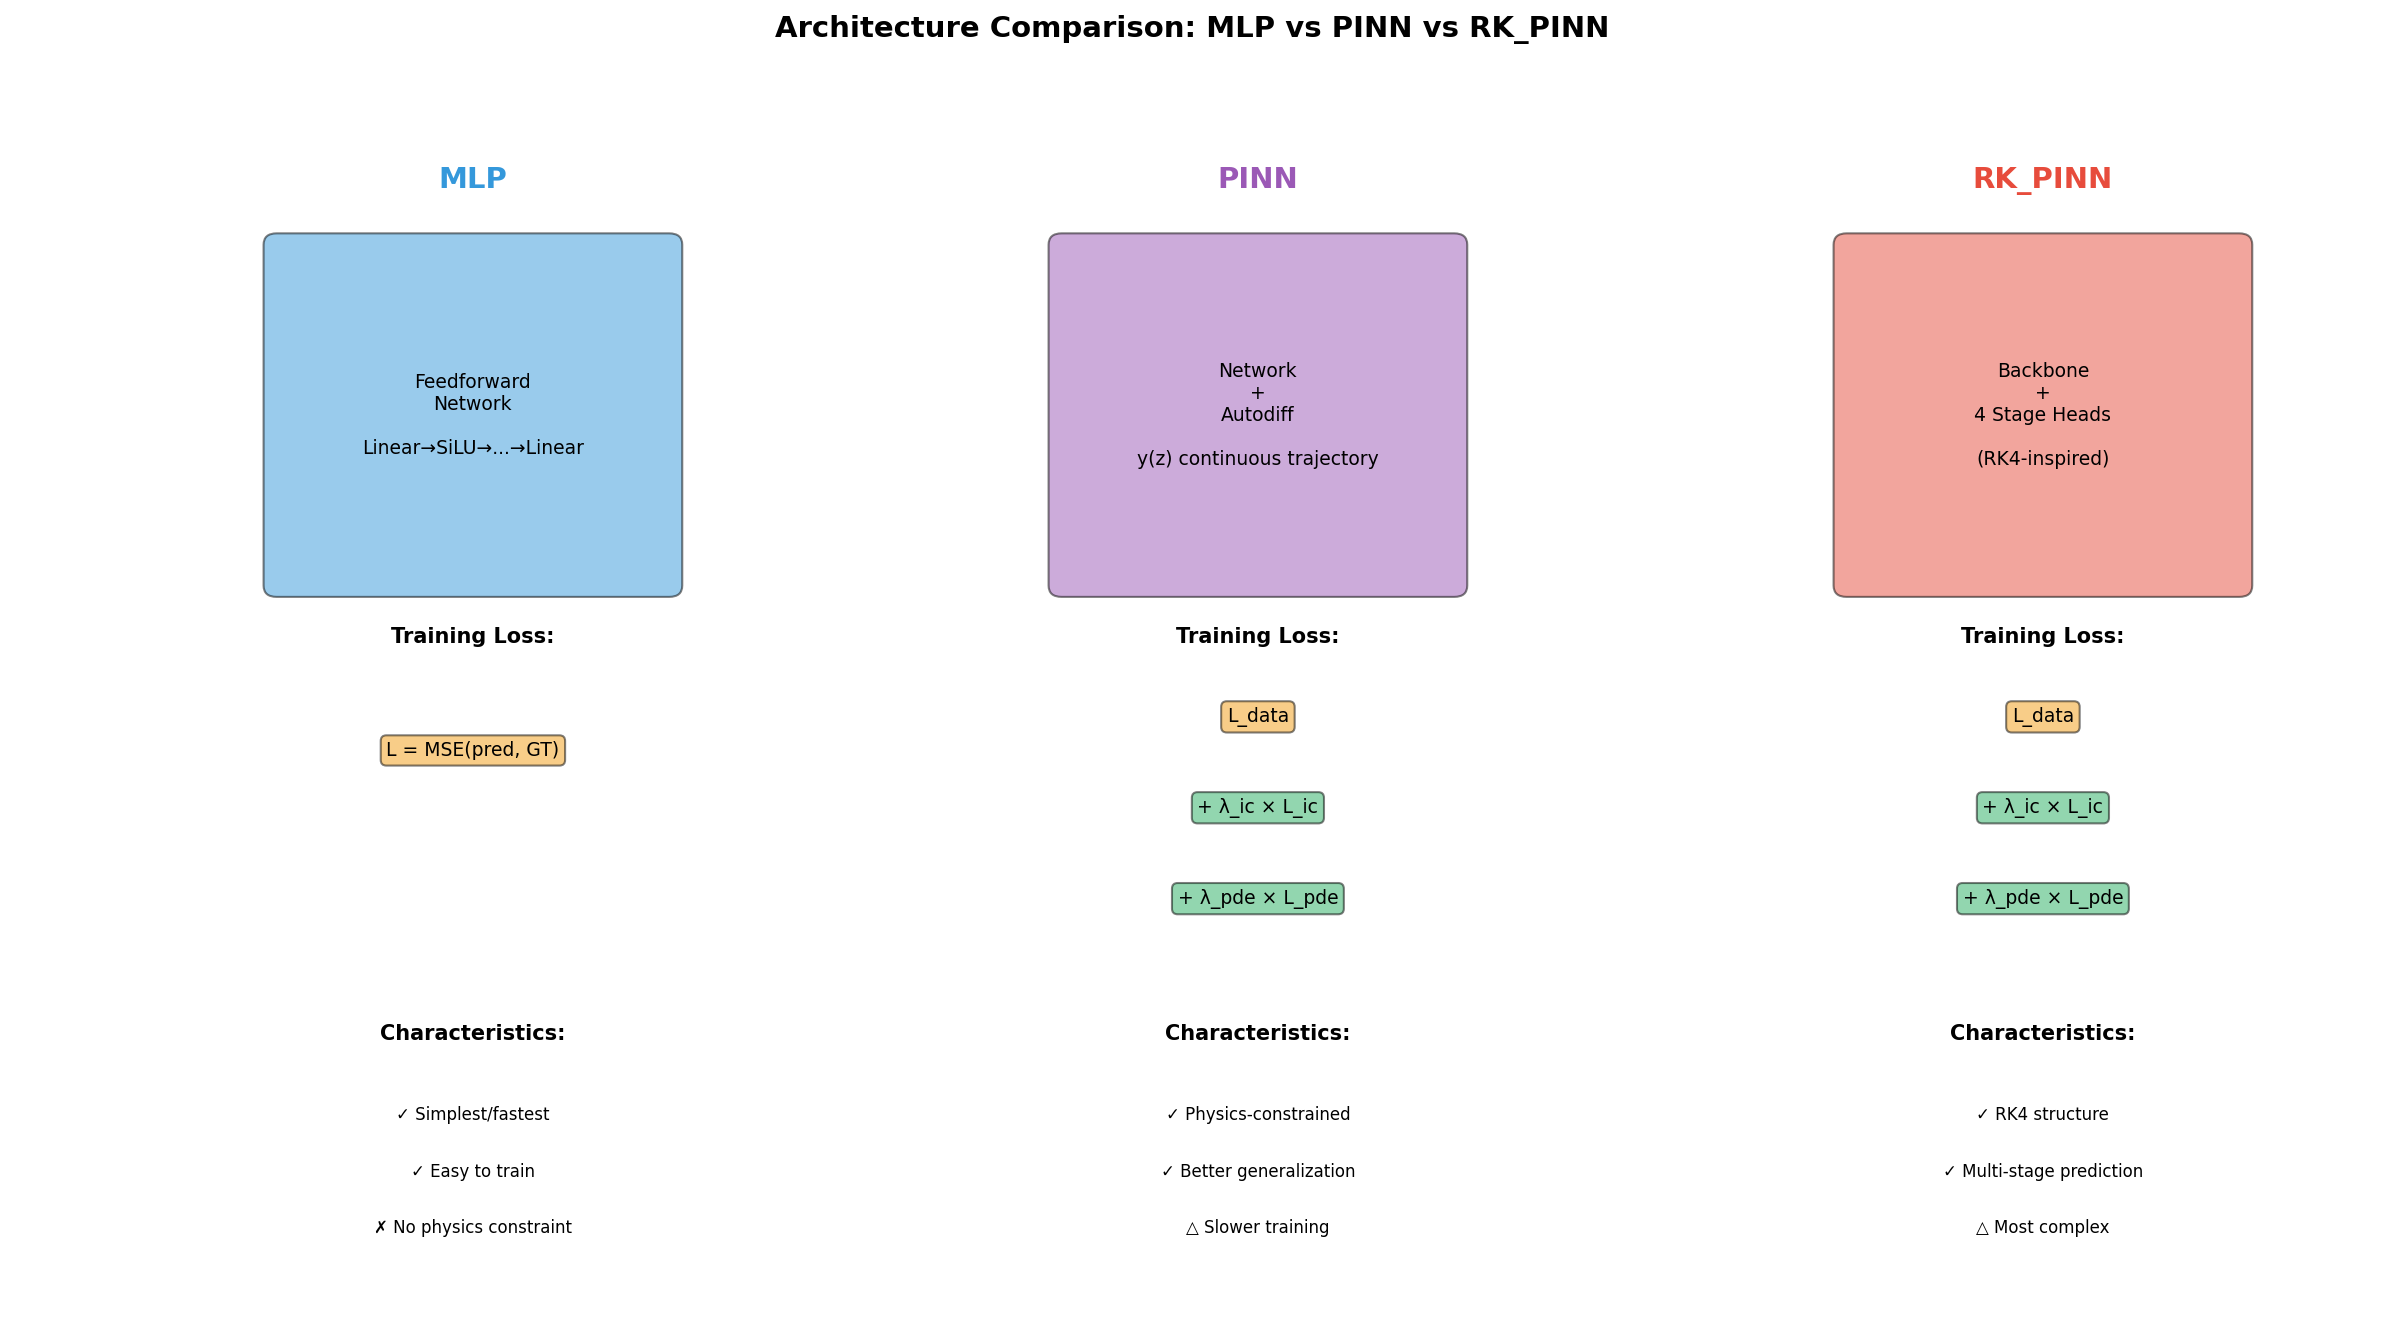

Architecture comparison saved to plots/architecture_comparison.png


In [5]:
def draw_architecture_comparison(ax):
    """
    Draw a side-by-side comparison of MLP, PINN, and RK_PINN.
    """
    colors = {
        'mlp': '#3498db',
        'pinn': '#9b59b6', 
        'rk_pinn': '#e74c3c',
        'physics': '#27ae60',
        'data': '#f39c12'
    }
    
    # Column positions
    cols = [2, 8, 14]
    titles = ['MLP', 'PINN', 'RK_PINN']
    col_colors = [colors['mlp'], colors['pinn'], colors['rk_pinn']]
    
    for col, title, color in zip(cols, titles, col_colors):
        # Title
        ax.text(col + 1.5, 9.5, title, ha='center', fontsize=14, fontweight='bold', color=color)
        
        # Network structure box
        net_box = FancyBboxPatch((col, 6), 3, 3, boxstyle="round,pad=0.1",
                                  fc=color, ec='black', alpha=0.5)
        ax.add_patch(net_box)
        
        if title == 'MLP':
            ax.text(col + 1.5, 7.5, 'Feedforward\nNetwork\n\nLinear→SiLU→...→Linear',
                   ha='center', va='center', fontsize=9)
        elif title == 'PINN':
            ax.text(col + 1.5, 7.5, 'Network\n+\nAutodiff\n\ny(z) continuous trajectory',
                   ha='center', va='center', fontsize=9)
        else:
            ax.text(col + 1.5, 7.5, 'Backbone\n+\n4 Stage Heads\n\n(RK4-inspired)',
                   ha='center', va='center', fontsize=9)
        
        # Loss components
        ax.text(col + 1.5, 5.5, 'Training Loss:', ha='center', fontsize=10, fontweight='bold')
        
        if title == 'MLP':
            loss_text = 'L = MSE(pred, GT)'
            ax.text(col + 1.5, 4.5, loss_text, ha='center', fontsize=9, 
                   bbox=dict(boxstyle='round', facecolor=colors['data'], alpha=0.5))
        else:
            ax.text(col + 1.5, 4.8, 'L_data', ha='center', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor=colors['data'], alpha=0.5))
            ax.text(col + 1.5, 4.0, '+ λ_ic × L_ic', ha='center', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor=colors['physics'], alpha=0.5))
            ax.text(col + 1.5, 3.2, '+ λ_pde × L_pde', ha='center', fontsize=9,
                   bbox=dict(boxstyle='round', facecolor=colors['physics'], alpha=0.5))
        
        # Characteristics
        ax.text(col + 1.5, 2.0, 'Characteristics:', ha='center', fontsize=10, fontweight='bold')
        
        if title == 'MLP':
            chars = ['✓ Simplest/fastest', '✓ Easy to train', '✗ No physics constraint']
        elif title == 'PINN':
            chars = ['✓ Physics-constrained', '✓ Better generalization', '△ Slower training']
        else:
            chars = ['✓ RK4 structure', '✓ Multi-stage prediction', '△ Most complex']
        
        for i, c in enumerate(chars):
            ax.text(col + 1.5, 1.3 - i * 0.5, c, ha='center', fontsize=8)
    
    ax.set_xlim(0, 18)
    ax.set_ylim(-0.5, 10.5)
    ax.axis('off')
    ax.set_title('Architecture Comparison: MLP vs PINN vs RK_PINN', fontsize=14, fontweight='bold', y=1.02)

# Create comparison
fig, ax = plt.subplots(figsize=(16, 9))
draw_architecture_comparison(ax)
plt.tight_layout()
plt.savefig('plots/architecture_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Architecture comparison saved to plots/architecture_comparison.png")

## 5. Load V1 Model Details and Create Summary Table

Found 24 V1 models


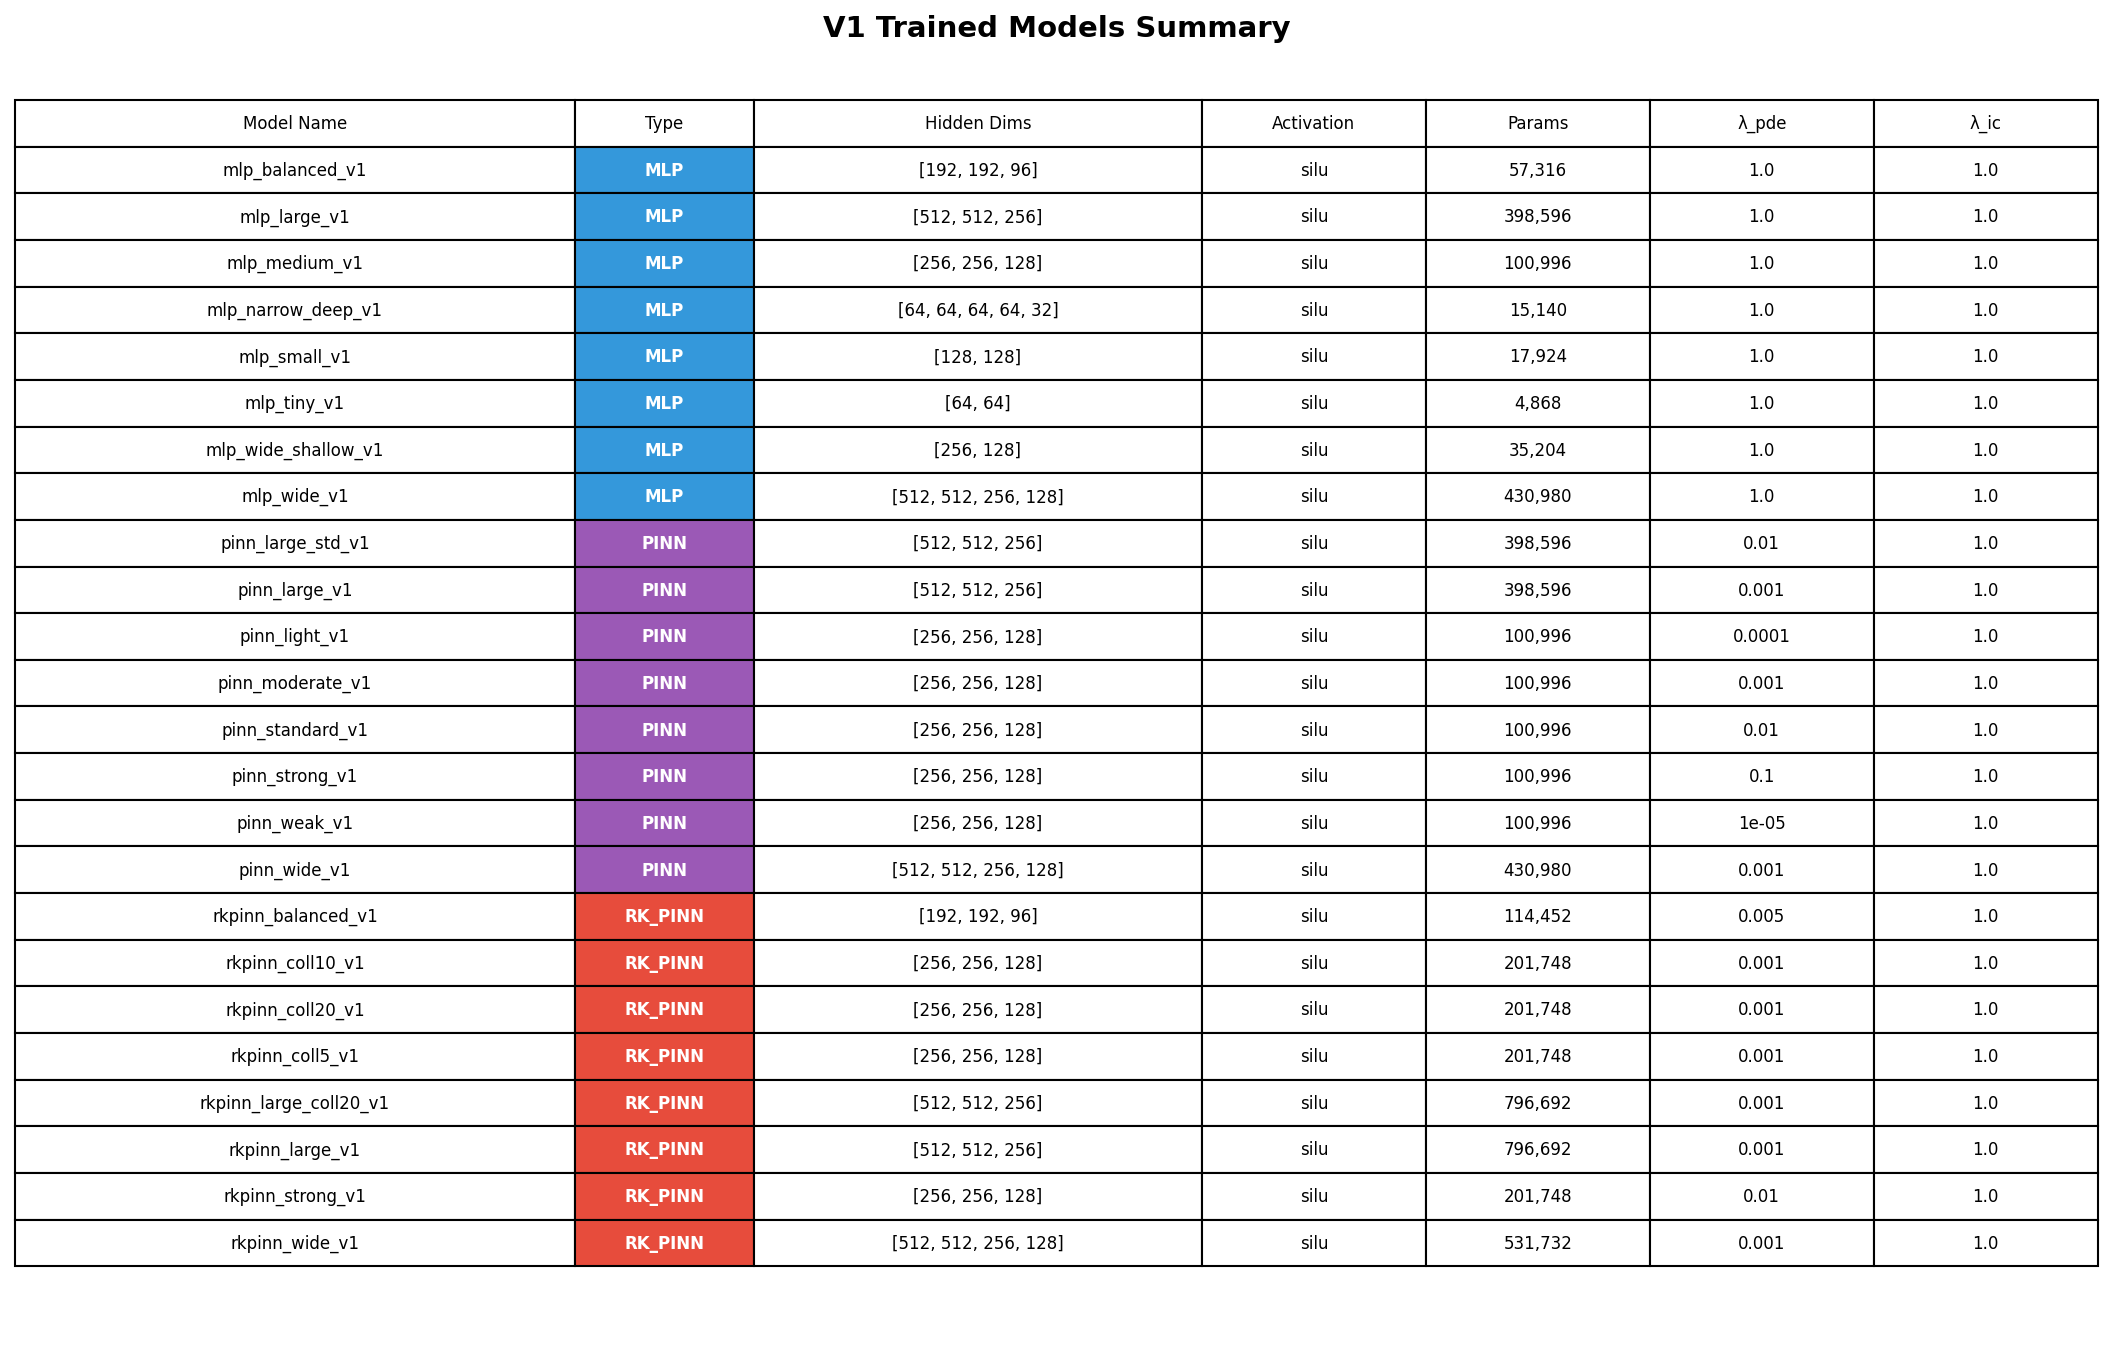


V1 models table saved to plots/v1_models_table.png


In [6]:
# Scan trained models directory for V1 models
trained_dir = Path('../trained_models')
v1_models = []

for model_dir in sorted(trained_dir.iterdir()):
    if model_dir.is_dir() and '_v1' in model_dir.name:
        config_file = model_dir / 'config.json'
        if config_file.exists():
            with open(config_file) as f:
                config = json.load(f)
            
            # Create model to count parameters
            model_type = config.get('model_type', 'mlp')
            hidden_dims = config.get('hidden_dims', [256, 256, 128])
            
            try:
                model = create_model(model_type, hidden_dims=hidden_dims)
                param_count = model.count_parameters()
            except:
                param_count = 'N/A'
            
            v1_models.append({
                'name': model_dir.name,
                'type': model_type.upper(),
                'hidden_dims': hidden_dims,
                'activation': config.get('activation', 'silu'),
                'params': param_count,
                'lambda_pde': config.get('lambda_pde', '-'),
                'lambda_ic': config.get('lambda_ic', '-'),
            })

print(f"Found {len(v1_models)} V1 models")

# Create table visualization
fig, ax = plt.subplots(figsize=(14, 0.3 * len(v1_models) + 2))
ax.axis('off')

# Table header
headers = ['Model Name', 'Type', 'Hidden Dims', 'Activation', 'Params', 'λ_pde', 'λ_ic']
col_widths = [0.25, 0.08, 0.2, 0.1, 0.1, 0.1, 0.1]

# Draw table
table_data = []
for m in v1_models:
    params_str = f"{m['params']:,}" if isinstance(m['params'], int) else str(m['params'])
    table_data.append([
        m['name'], m['type'], str(m['hidden_dims']), m['activation'], 
        params_str, str(m['lambda_pde']), str(m['lambda_ic'])
    ])

table = ax.table(cellText=table_data, colLabels=headers, loc='center',
                 colWidths=col_widths, cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)

# Color code by model type
type_colors = {'MLP': '#3498db', 'PINN': '#9b59b6', 'RK_PINN': '#e74c3c'}
for i, m in enumerate(v1_models):
    table[(i+1, 1)].set_facecolor(type_colors.get(m['type'], 'white'))
    table[(i+1, 1)].set_text_props(color='white', weight='bold')

ax.set_title('V1 Trained Models Summary', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('plots/v1_models_table.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nV1 models table saved to plots/v1_models_table.png")

## 6. Parameter Count Comparison

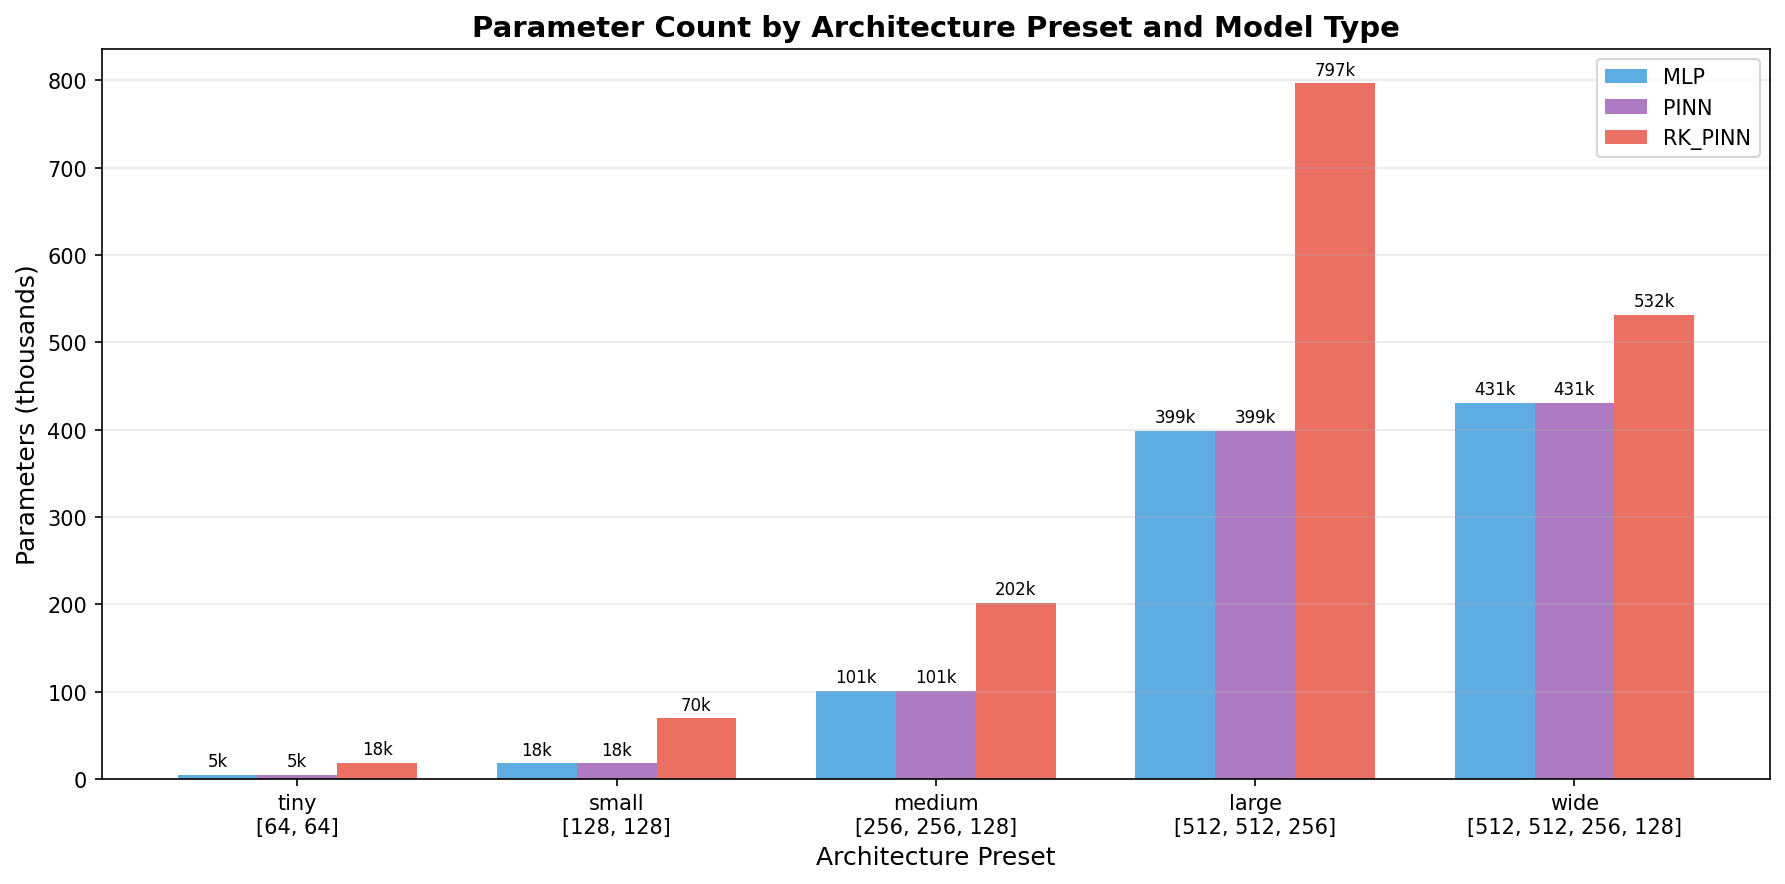

Parameter comparison saved to plots/parameter_comparison.png


In [7]:
# Calculate parameter counts for standard presets
preset_params = {}

for preset_name, preset_config in ARCHITECTURE_PRESETS.items():
    hidden_dims = preset_config['hidden_dims']
    
    for model_type in ['mlp', 'pinn', 'rk_pinn']:
        try:
            model = create_model(model_type, hidden_dims=hidden_dims)
            param_count = model.count_parameters()
            preset_params[(preset_name, model_type)] = param_count
        except Exception as e:
            print(f"Error creating {model_type} {preset_name}: {e}")

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

preset_names = list(ARCHITECTURE_PRESETS.keys())
model_types = ['mlp', 'pinn', 'rk_pinn']
colors = ['#3498db', '#9b59b6', '#e74c3c']
x = np.arange(len(preset_names))
width = 0.25

for i, (model_type, color) in enumerate(zip(model_types, colors)):
    params = [preset_params.get((p, model_type), 0) / 1000 for p in preset_names]  # in thousands
    bars = ax.bar(x + i * width, params, width, label=model_type.upper(), color=color, alpha=0.8)
    
    # Add value labels
    for bar, val in zip(bars, params):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                   f'{val:.0f}k', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Architecture Preset', fontsize=12)
ax.set_ylabel('Parameters (thousands)', fontsize=12)
ax.set_title('Parameter Count by Architecture Preset and Model Type', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels([f"{n}\n{ARCHITECTURE_PRESETS[n]['hidden_dims']}" for n in preset_names])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/parameter_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Parameter comparison saved to plots/parameter_comparison.png")

## Timing Benchmarks

Load actual timing data from benchmark results files.

In [14]:
# Load actual timing data from benchmark results
import pandas as pd

# Load NN model timing results
nn_timing_path = '../results/timing_benchmarks.csv'
nn_timing_df = pd.read_csv(nn_timing_path)
print("Neural Network Timing Results:")
print(nn_timing_df.to_string())

# Load C++ extrapolator benchmark results  
cpp_timing_path = '../benchmarking/results/benchmark_summary.csv'
cpp_timing_df = pd.read_csv(cpp_timing_path)
print("\n\nC++ Extrapolator Timing Results:")
print(cpp_timing_df.to_string())

# Load validation losses from all_model_results.csv
model_results_path = '../results/all_model_results.csv'
model_results_df = pd.read_csv(model_results_path)
print("\n\nModel Validation Losses (top 10):")
print(model_results_df[['name', 'model_type', 'n_params', 'best_val_loss']].head(10).to_string())

Neural Network Timing Results:
            model model_type  n_params  time_per_track_us  throughput_M_tracks_per_sec  speedup_vs_rk4
0        mlp_tiny        MLP      4868           1.123830                     0.889815       66.736093
1       pinn_tiny       PINN      4868           1.192162                     0.838812       62.910934
2       mlp_small        MLP     17924           1.221699                     0.818532       61.389892
3      pinn_small       PINN     17924           1.309178                     0.763838       57.287868
4      mlp_medium        MLP    100996           2.166852                     0.461499       34.612419
5     pinn_medium       PINN    100996           2.461029                     0.406334       30.475054
6     rkpinn_tiny    RK_PINN     18388           3.909174                     0.255809       19.185640
7    rkpinn_small    RK_PINN     69524           4.059129                     0.246358       18.476871
8       pinn_wide       PINN    430980    

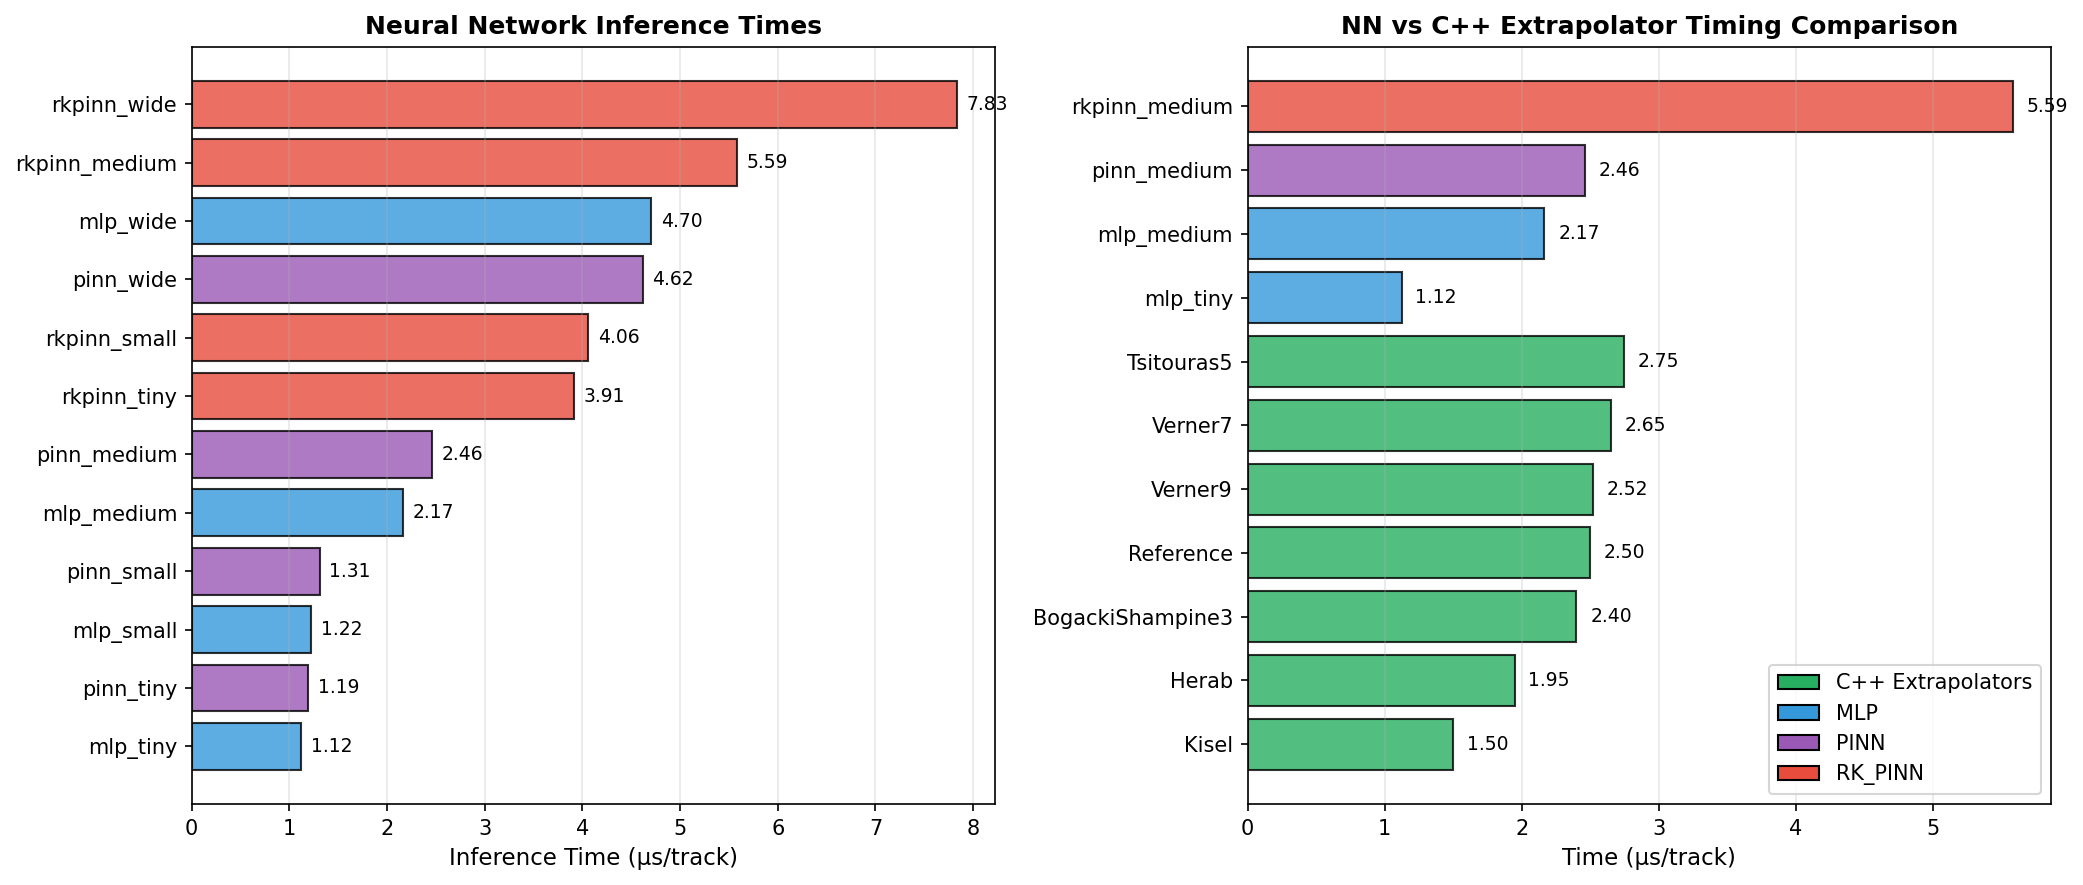

Timing benchmarks saved to plots/timing_benchmarks.png


In [15]:
# Create timing comparison visualization using actual data

# Merge NN timing with validation loss
nn_with_loss = nn_timing_df.merge(
    model_results_df[['name', 'best_val_loss']], 
    left_on='model', right_on='name', how='left'
)

# Create figure with timing comparisons
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Colors by model type
def get_color(model_type):
    colors = {'MLP': '#3498db', 'PINN': '#9b59b6', 'RK_PINN': '#e74c3c'}
    return colors.get(model_type, '#95a5a6')

nn_colors = [get_color(t) for t in nn_timing_df['model_type']]

# Plot 1: NN inference times
ax1 = axes[0]
models = nn_timing_df['model'].tolist()
times = nn_timing_df['time_per_track_us'].tolist()

bars1 = ax1.barh(models, times, color=nn_colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Inference Time (μs/track)', fontsize=11)
ax1.set_title('Neural Network Inference Times', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add time labels
for bar, t in zip(bars1, times):
    ax1.text(t + 0.1, bar.get_y() + bar.get_height()/2, f'{t:.2f}', va='center', fontsize=9)

# Plot 2: Compare NN vs C++ extrapolators
ax2 = axes[1]

# Get comparable data
cpp_names = cpp_timing_df['Extrapolator'].tolist()
cpp_times = cpp_timing_df['Mean Time (μs)'].tolist()
cpp_errors = cpp_timing_df['Mean Error (mm)'].tolist()

# Select representative NN models for comparison
representative_nn = nn_timing_df[nn_timing_df['model'].isin(['mlp_tiny', 'mlp_medium', 'pinn_medium', 'rkpinn_medium'])]

all_names = cpp_names + representative_nn['model'].tolist()
all_times = cpp_times + representative_nn['time_per_track_us'].tolist()
all_colors = ['#27ae60'] * len(cpp_names) + [get_color(t) for t in representative_nn['model_type']]

bars2 = ax2.barh(all_names, all_times, color=all_colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Time (μs/track)', fontsize=11)
ax2.set_title('NN vs C++ Extrapolator Timing Comparison', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add time labels
for bar, t in zip(bars2, all_times):
    ax2.text(t + 0.1, bar.get_y() + bar.get_height()/2, f'{t:.2f}', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', edgecolor='black', label='C++ Extrapolators'),
    Patch(facecolor='#3498db', edgecolor='black', label='MLP'),
    Patch(facecolor='#9b59b6', edgecolor='black', label='PINN'),
    Patch(facecolor='#e74c3c', edgecolor='black', label='RK_PINN'),
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('plots/timing_benchmarks.png', dpi=150, bbox_inches='tight')
plt.show()
print("Timing benchmarks saved to plots/timing_benchmarks.png")

## 7. Interactive Network Visualization with PyTorch

In [8]:
# Create actual model instances and print their structure
print("="*60)
print("V1 MODEL ARCHITECTURES")
print("="*60)

# MLP Medium (most common V1 configuration)
print("\n" + "-"*40)
print("MLP [256, 256, 128] - 'Medium' preset")
print("-"*40)
mlp = MLP(hidden_dims=[256, 256, 128], activation='silu')
print(mlp)
print(f"\nTotal parameters: {mlp.count_parameters():,}")

# PINN Medium
print("\n" + "-"*40)
print("PINN [256, 256, 128] - 'Medium' preset")
print("-"*40)
pinn = PINN(hidden_dims=[256, 256, 128], activation='tanh', lambda_pde=1.0, lambda_ic=1.0)
print(pinn)
print(f"\nTotal parameters: {pinn.count_parameters():,}")

# RK_PINN Medium  
print("\n" + "-"*40)
print("RK_PINN [256, 256, 128] - 'Medium' preset")
print("-"*40)
rk_pinn = RK_PINN(hidden_dims=[256, 256, 128], activation='tanh')
print(rk_pinn)
print(f"\nTotal parameters: {rk_pinn.count_parameters():,}")
print(f"Stage fractions: {rk_pinn.stage_fractions.tolist()}")
print(f"Stage weights (init): {torch.nn.functional.softmax(rk_pinn.stage_weights, dim=0).tolist()}")

V1 MODEL ARCHITECTURES

----------------------------------------
MLP [256, 256, 128] - 'Medium' preset
----------------------------------------
MLP(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

Total parameters: 100,996

----------------------------------------
PINN [256, 256, 128] - 'Medium' preset
----------------------------------------
PINN(
  (field): InterpolatedFieldTorch()
  (network): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

Total paramet

## Summary

We've visualized the three V1 neural network architectures:

1. **MLP**: Standard feedforward network, trained with data loss only
2. **PINN**: Same network + physics loss (initial condition + PDE residual via autodiff)
3. **RK_PINN**: Multi-stage architecture inspired by RK4, with shared backbone and 4 stage heads

### Key architectural differences:

| Feature | MLP | PINN | RK_PINN |
|---------|-----|------|--------|
| Network | Sequential | Sequential + autodiff | Backbone + 4 heads |
| Loss | L_data | L_data + L_ic + L_pde | L_data + L_ic + L_pde |
| Training | Fast | Slower (autodiff) | Slowest |
| Physics | None | Lorentz force PDE | Lorentz + RK4 structure |
| Params | ~100k | ~100k | ~120k (same hidden dims) |